# Fashion-MNIST Classification with an MDA Head
This notebook trains a small convolutional encoder with a mixture discriminant analysis (MDA) head 
on Fashion-MNIST, then evaluates calibration plots.


### Setup


In [1]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from dnll import MDAHead, EM_DNLLLoss


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)


device = cuda


### Data


In [3]:
tfm = transforms.ToTensor()
train_ds = datasets.FashionMNIST(root='./data', train=True, transform=tfm, download=True)
test_ds  = datasets.FashionMNIST(root='./data', train=False, transform=tfm, download=True)
train_ld = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
test_ld  = DataLoader(test_ds,  batch_size=1024, shuffle=False, num_workers=2, pin_memory=True)
len(train_ds), len(test_ds)


(60000, 10000)

### Model: encoder + MDA head


In [4]:
class Encoder(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
        )
        self.proj = nn.Linear(256, dim)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.proj(x)

class DeepMDA(nn.Module):
    def __init__(self, C, D, K):
        super().__init__()
        self.encoder = Encoder(D)
        self.head = MDAHead(C, D, K)

    def forward(self, x):
        z = self.encoder(x)
        return self.head(z)


### Train & Eval


In [5]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    ok = tot = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        ok += (logits.argmax(1) == y).sum().item()
        tot += y.size(0)
    return ok / tot


model = DeepMDA(C=10, D=2, K=2).to(device)
opt = torch.optim.Adam(model.parameters())
loss_fn = EM_DNLLLoss()

train_acc = []
test_acc = []

for epoch in range(1, 101):
    model.train()
    loss_sum = acc_sum = n_sum = 0
    for x, y in train_ld:
        x, y = x.to(device), y.to(device)
        z = model.encoder(x)
        loss = loss_fn(model.head, z, y)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        with torch.no_grad():
            logits = model.head(z)
            pred = logits.argmax(1)
            acc_sum += (pred == y).sum().item()
            n_sum += y.size(0)
            loss_sum += loss.item() * y.size(0)
    tr_acc = acc_sum / n_sum
    te_acc = evaluate(model, test_ld)
    train_acc.append(tr_acc)
    test_acc.append(te_acc)
    print(f'[MDA {epoch:02d}] train loss={loss_sum/n_sum:.4f} acc={tr_acc:.4f} | test acc={te_acc:.4f}')


[MDA 01] train loss=4.3545 acc=0.5311 | test acc=0.6314
[MDA 02] train loss=3.6237 acc=0.6798 | test acc=0.6012
[MDA 03] train loss=3.2705 acc=0.7208 | test acc=0.6737
[MDA 04] train loss=2.9979 acc=0.7377 | test acc=0.7341
[MDA 05] train loss=2.7690 acc=0.7538 | test acc=0.7276
[MDA 06] train loss=2.5608 acc=0.7738 | test acc=0.7751
[MDA 07] train loss=2.3940 acc=0.7991 | test acc=0.8113
[MDA 08] train loss=2.2442 acc=0.8239 | test acc=0.8183
[MDA 09] train loss=2.0886 acc=0.8504 | test acc=0.8081
[MDA 10] train loss=1.9731 acc=0.8622 | test acc=0.7734
[MDA 11] train loss=1.8604 acc=0.8726 | test acc=0.8160
[MDA 12] train loss=1.7421 acc=0.8857 | test acc=0.8182
[MDA 13] train loss=1.6550 acc=0.8938 | test acc=0.8393
[MDA 14] train loss=1.5904 acc=0.9007 | test acc=0.8557
[MDA 15] train loss=1.5026 acc=0.9124 | test acc=0.8722
[MDA 16] train loss=1.4461 acc=0.9214 | test acc=0.8481
[MDA 17] train loss=1.3870 acc=0.9298 | test acc=0.8782
[MDA 18] train loss=1.3499 acc=0.9364 | test acc

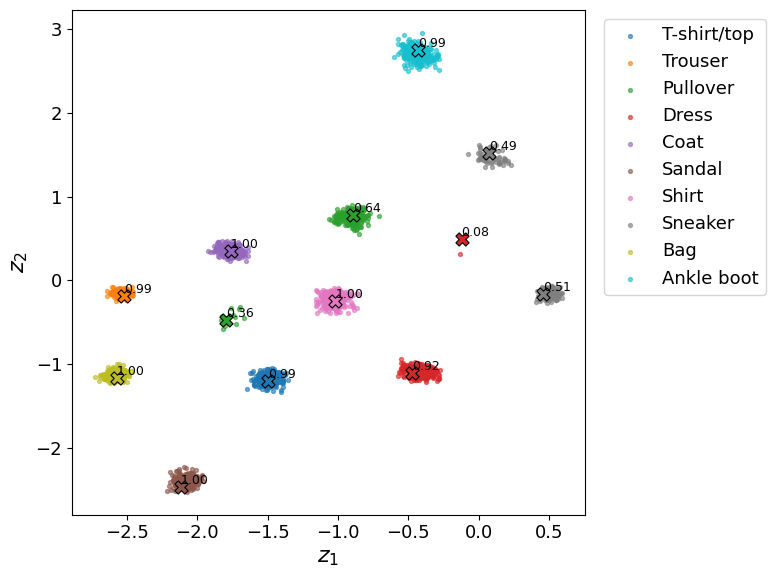

In [6]:
import matplotlib.pyplot as plt

model.eval()
embeds, labels = [], []
with torch.no_grad():
    for i, (x, y) in enumerate(train_ld):   # use train_ld if you prefer
        x = x.to(device)
        z = model.encoder(x).cpu()
        embeds.append(z)
        labels.append(y)
        if i >= 9:   # 10 batches ≈10k points; raise/lower to taste
            break

z2 = torch.cat(embeds)
y = torch.cat(labels)

mu = model.head.mu.detach().cpu().numpy()  # (C, K, D)
mix_probs = torch.softmax(model.head.mixture_logits, dim=-1).detach().cpu().numpy()

plt.rcParams.update({
    "font.size": 14, "axes.labelsize": 16, "legend.fontsize": 13,
    "xtick.labelsize": 13, "ytick.labelsize": 13
})

plt.figure(figsize=(8, 6))
ax = plt.gca()
for c in range(10):
    idx = y == c
    color = plt.cm.tab10(c)
    plt.scatter(z2[idx, 0], z2[idx, 1], s=8, alpha=0.6, color=color, label=train_ds.classes[c])
    for k in range(mu.shape[1]):
        if mix_probs[c, k] < 0.05:
            continue
        plt.scatter(mu[c, k, 0], mu[c, k, 1], s=90, marker='X',
                    color=color, edgecolor='black', linewidths=0.8)
        ax.text(mu[c, k, 0], mu[c, k, 1], f"{mix_probs[c, k]:.2f}",
                fontsize=9, ha='left', va='bottom', color='black')
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.xlabel("$z_1$"); plt.ylabel("$z_2$")
plt.tight_layout()
plt.savefig('plots/fashion_mnist_mda_embeddings.png', dpi=600)


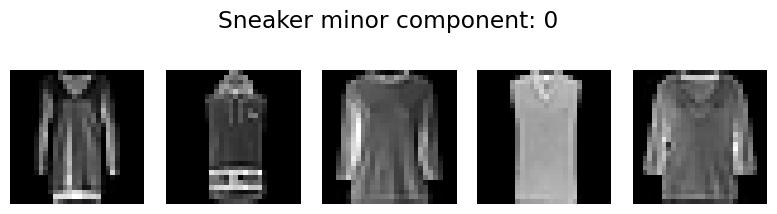

In [20]:
# Show Sneaker examples from minor component
sneaker_idx = train_ds.classes.index("Pullover")
minor_comp = int(torch.softmax(model.head.mixture_logits[sneaker_idx], dim=-1).argmin().item())
num_examples = 5
sneaker_examples = []

with torch.no_grad():
    for x, y in train_ld:
        mask = y == sneaker_idx
        if not mask.any():
            continue
        xb = x[mask].to(device)
        z = model.encoder(xb)

        mu_s = model.head.mu[sneaker_idx].to(z.dtype)
        log_cov_s = model.head.log_cov[sneaker_idx].to(z.dtype)
        log_mix_s = torch.log_softmax(model.head.mixture_logits[sneaker_idx], dim=-1)

        diff = z.unsqueeze(1) - mu_s.unsqueeze(0)
        m2 = (diff * diff).sum(-1)
        var = torch.exp(log_cov_s)
        log_det = model.head.D * log_cov_s
        log_comp = -0.5 * (m2 / var.unsqueeze(0) + log_det.unsqueeze(0))
        log_r = log_mix_s.unsqueeze(0) + log_comp
        comp = log_r.argmax(dim=-1)

        sel = (comp == minor_comp).nonzero(as_tuple=False).squeeze(1)
        for j in sel:
            if len(sneaker_examples) >= num_examples:
                break
            sneaker_examples.append(xb[j].cpu())

        if len(sneaker_examples) >= num_examples:
            break

fig, axes = plt.subplots(1, num_examples, figsize=(1.6 * num_examples, 2.2))
for j in range(num_examples):
    ax = axes[j]
    ax.axis("off")
    if j < len(sneaker_examples):
        ax.imshow(sneaker_examples[j].squeeze(0), cmap="gray")
fig.suptitle(f"Sneaker minor component: {minor_comp}")
plt.tight_layout()
plt.show()


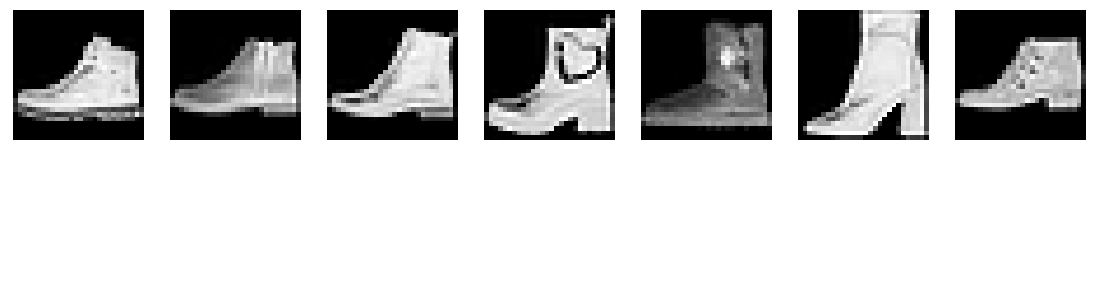

In [28]:
# Show Bag examples for both mixture components
bag_idx = train_ds.classes.index("Ankle boot")
n_per_comp = 7
bag_examples = {k: [] for k in range(model.head.K)}

with torch.no_grad():
    for x, y in train_ld:
        mask = y == bag_idx
        if not mask.any():
            continue
        xb = x[mask].to(device)
        z = model.encoder(xb)

        mu_b = model.head.mu[bag_idx].to(z.dtype)
        log_cov_b = model.head.log_cov[bag_idx].to(z.dtype)
        log_mix_b = torch.log_softmax(model.head.mixture_logits[bag_idx], dim=-1)

        diff = z.unsqueeze(1) - mu_b.unsqueeze(0)
        m2 = (diff * diff).sum(-1)
        var = torch.exp(log_cov_b)
        log_det = model.head.D * log_cov_b
        log_comp = -0.5 * (m2 / var.unsqueeze(0) + log_det.unsqueeze(0))
        log_r = log_mix_b.unsqueeze(0) + log_comp
        comp = log_r.argmax(dim=-1)

        for k in range(model.head.K):
            if len(bag_examples[k]) >= n_per_comp:
                continue
            k_idx = (comp == k).nonzero(as_tuple=False).squeeze(1)
            for j in k_idx:
                if len(bag_examples[k]) >= n_per_comp:
                    break
                bag_examples[k].append(xb[j].cpu())

        if all(len(bag_examples[k]) >= n_per_comp for k in range(model.head.K)):
            break

fig, axes = plt.subplots(model.head.K, n_per_comp, figsize=(1.6 * n_per_comp, 3.2))
if model.head.K == 1:
    axes = [axes]
for k in range(model.head.K):
    for j in range(n_per_comp):
        ax = axes[k][j] if model.head.K > 1 else axes[j]
        ax.axis("off")
        if j < len(bag_examples[k]):
            ax.imshow(bag_examples[k][j].squeeze(0), cmap="gray")
    if model.head.K > 1:
        axes[k][0].set_ylabel(f"Bag comp {k}", rotation=0, labelpad=30, va="center")
plt.tight_layout()
plt.show()


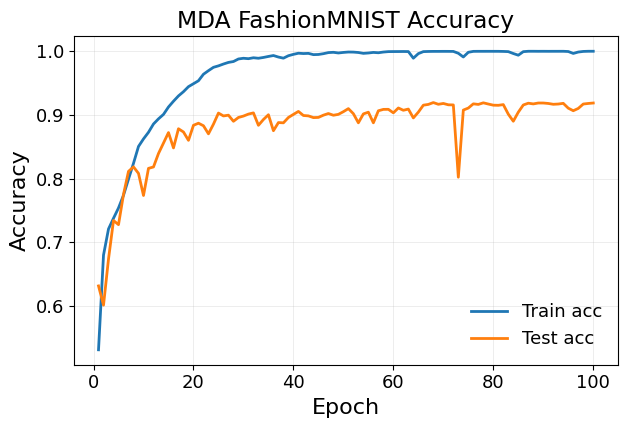

In [9]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc) + 1)
plt.figure(figsize=(6.5, 4.5))
plt.plot(epochs, train_acc, label='Train acc', linewidth=2)
plt.plot(epochs, test_acc, label='Test acc', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MDA FashionMNIST Accuracy')
plt.legend(frameon=False)
plt.grid(True, linewidth=0.4, alpha=0.4)
plt.tight_layout()
plt.show()
